<a href="https://colab.research.google.com/github/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/04_pytorch_custom_datasets_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [81]:
# Check for GPU
!nvidia-smi

Thu Jul 20 13:57:53 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3080      WDDM  | 00000000:01:00.0  On |                  N/A |
| 34%   33C    P5              45W / 380W |   3380MiB / 10240MiB |     39%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [82]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.0.1+cu117


'cuda'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

Train for longer- more time to learn data represenataions

Add more layers/ hidden units - model may not be able to learn needed patterns 

Tweak learning rate - model may be trying to learn too fast and overstepping

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [83]:
# 1. Get data
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} dir exists")
else:
    print(f"Could not find image path: {image_path}, creating now")
    image_path.mkdir(parents=True, exist_ok=True)

    with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        f.write(request.content)

    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping")
        zip_ref.extractall(image_path)

data\pizza_steak_sushi dir exists


In [84]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [85]:
# Setup train and testing paths
train_dir = image_path / "train"

test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Image class: sushi
Image height: 408
Image width: 512


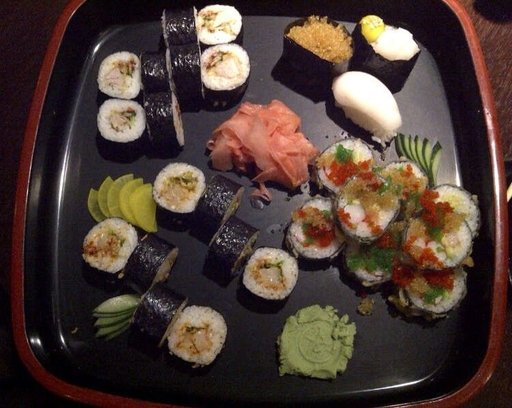

In [86]:
# Visualize an image
import random
from PIL import Image

random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

<function matplotlib.pyplot.show(close=None, block=None)>

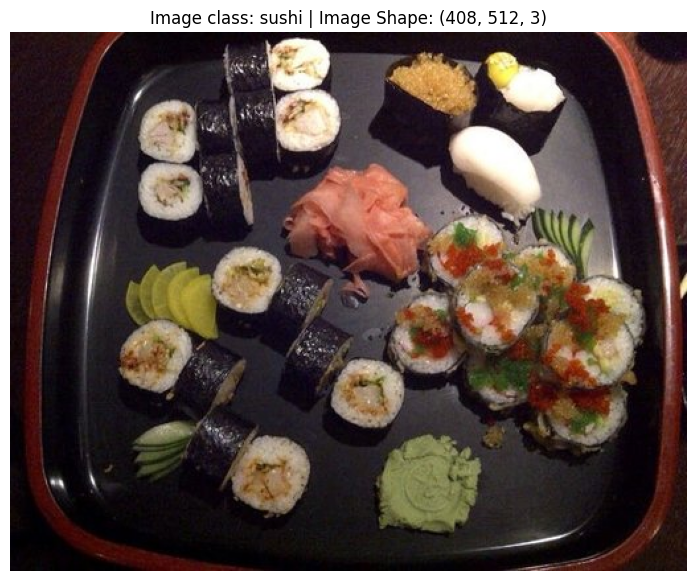

In [87]:
# Do the image visualization with matplotlib
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image Shape: {img_as_array.shape}")
plt.axis(False)
plt.show

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [88]:
# 3.1 Transforming data with torchvision.transforms
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [89]:
# Write transform for turning images into tensors
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

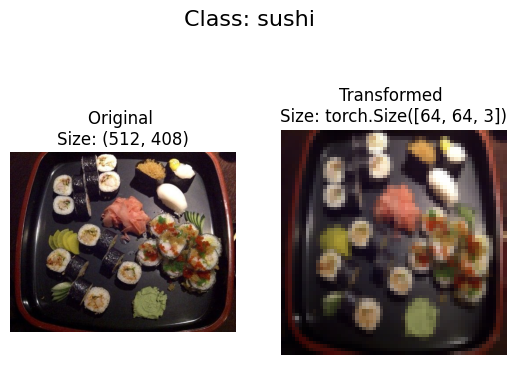

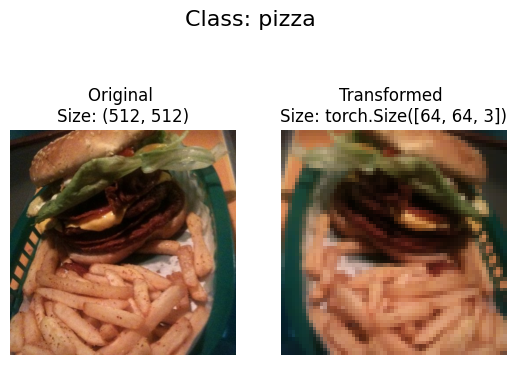

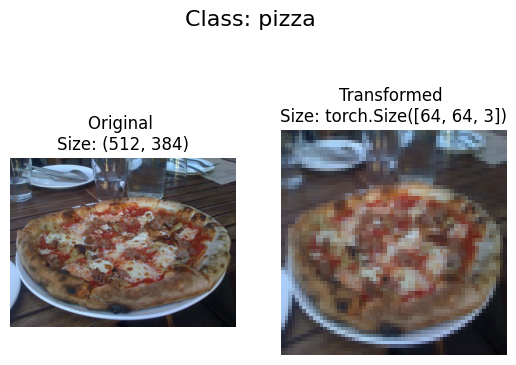

In [90]:
# Write a function to plot transformed images
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

### Load image data using `ImageFolder`

In [91]:
# Use ImageFolder to create dataset(s)

from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data: {train_data}, Test data: {test_data}")


Train data: Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           ), Test data: Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [92]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [93]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [94]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [95]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=os.cpu_count(),
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x175692ab050>,
 <torch.utils.data.dataloader.DataLoader at 0x175692abb90>)

In [96]:
# How many batches of images are in our data loaders?
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape}, bs cc h w")

Image shape: torch.Size([1, 3, 64, 64]), bs cc h w


## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [97]:
import torch
from torch import nn

class TinyVGG(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16,
                  out_features=output_shape))
        
  def forward(self, x):
    x = self.conv_block_1(x)
    # print(f"Layer 1 shape: {x.shape}")
    x = self.conv_block_2(x)
    # print(f"Layer 2 shape: {x.shape}")
    x = self.classifier(x)
    # print(f"Layer 3 shape: {x.shape}")
    return x

## 4. Create training and testing functions for `model_0`.

In [98]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device) 

    # 1. Forward pass
    y_pred = model(X)
    # print(y_pred)

    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad 
    optimizer.zero_grad()

    # 4. Loss backward 
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and average accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc 

In [99]:

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  
  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)
      # print(test_pred_logits)

      # 2. Calculuate and accumulate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
    
  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [100]:

from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
  
  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model, 
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model, 
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    
    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer. 

In [101]:
# Train for 5 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:07<00:29,  7.47s/it]

Epoch: 1 | train_loss: 1.1177 | train_acc: 0.2978 | test_loss: 1.0963 | test_acc: 0.3333


 40%|████      | 2/5 [00:14<00:22,  7.40s/it]

Epoch: 2 | train_loss: 1.1012 | train_acc: 0.3244 | test_loss: 1.0998 | test_acc: 0.2533


 60%|██████    | 3/5 [00:22<00:14,  7.33s/it]

Epoch: 3 | train_loss: 1.0994 | train_acc: 0.3022 | test_loss: 1.0999 | test_acc: 0.3333


 80%|████████  | 4/5 [00:29<00:07,  7.27s/it]

Epoch: 4 | train_loss: 1.0990 | train_acc: 0.3289 | test_loss: 1.1001 | test_acc: 0.3467


100%|██████████| 5/5 [00:36<00:00,  7.32s/it]

Epoch: 5 | train_loss: 1.0989 | train_acc: 0.3200 | test_loss: 1.1005 | test_acc: 0.3333


In [102]:

# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=20)

  5%|▌         | 1/20 [00:07<02:22,  7.50s/it]

Epoch: 1 | train_loss: 1.1177 | train_acc: 0.2978 | test_loss: 1.0960 | test_acc: 0.3333


 10%|█         | 2/20 [00:14<02:11,  7.31s/it]

Epoch: 2 | train_loss: 1.1033 | train_acc: 0.3467 | test_loss: 1.1130 | test_acc: 0.2533


 15%|█▌        | 3/20 [00:21<02:02,  7.20s/it]

Epoch: 3 | train_loss: 1.1041 | train_acc: 0.3333 | test_loss: 1.0984 | test_acc: 0.3333


 20%|██        | 4/20 [00:29<01:55,  7.23s/it]

Epoch: 4 | train_loss: 1.0991 | train_acc: 0.3156 | test_loss: 1.0991 | test_acc: 0.3333


 25%|██▌       | 5/20 [00:36<01:48,  7.22s/it]

Epoch: 5 | train_loss: 1.0990 | train_acc: 0.3022 | test_loss: 1.0998 | test_acc: 0.3333


 30%|███       | 6/20 [00:43<01:40,  7.20s/it]

Epoch: 6 | train_loss: 1.0990 | train_acc: 0.3467 | test_loss: 1.1004 | test_acc: 0.3333


 35%|███▌      | 7/20 [00:50<01:33,  7.23s/it]

Epoch: 7 | train_loss: 1.0988 | train_acc: 0.3467 | test_loss: 1.1005 | test_acc: 0.3333


 40%|████      | 8/20 [00:57<01:26,  7.23s/it]

Epoch: 8 | train_loss: 1.0988 | train_acc: 0.3467 | test_loss: 1.1012 | test_acc: 0.3333


 45%|████▌     | 9/20 [01:05<01:19,  7.24s/it]

Epoch: 9 | train_loss: 1.0988 | train_acc: 0.3467 | test_loss: 1.1012 | test_acc: 0.3333


 50%|█████     | 10/20 [01:12<01:12,  7.23s/it]

Epoch: 10 | train_loss: 1.0988 | train_acc: 0.3467 | test_loss: 1.1013 | test_acc: 0.3333


 55%|█████▌    | 11/20 [01:19<01:05,  7.25s/it]

Epoch: 11 | train_loss: 1.0989 | train_acc: 0.3467 | test_loss: 1.1018 | test_acc: 0.3333


 60%|██████    | 12/20 [01:26<00:57,  7.24s/it]

Epoch: 12 | train_loss: 1.0987 | train_acc: 0.3467 | test_loss: 1.1012 | test_acc: 0.3333


 65%|██████▌   | 13/20 [01:33<00:50,  7.17s/it]

Epoch: 13 | train_loss: 1.0988 | train_acc: 0.3467 | test_loss: 1.1016 | test_acc: 0.3333


 70%|███████   | 14/20 [01:41<00:43,  7.19s/it]

Epoch: 14 | train_loss: 1.0987 | train_acc: 0.3467 | test_loss: 1.1012 | test_acc: 0.3333


 75%|███████▌  | 15/20 [01:48<00:36,  7.20s/it]

Epoch: 15 | train_loss: 1.0986 | train_acc: 0.3467 | test_loss: 1.1016 | test_acc: 0.3333


 80%|████████  | 16/20 [01:55<00:28,  7.20s/it]

Epoch: 16 | train_loss: 1.0987 | train_acc: 0.3467 | test_loss: 1.1012 | test_acc: 0.3333


 85%|████████▌ | 17/20 [02:02<00:21,  7.20s/it]

Epoch: 17 | train_loss: 1.0986 | train_acc: 0.3467 | test_loss: 1.1024 | test_acc: 0.3333


 90%|█████████ | 18/20 [02:10<00:14,  7.23s/it]

Epoch: 18 | train_loss: 1.0986 | train_acc: 0.3467 | test_loss: 1.1032 | test_acc: 0.3333


 95%|█████████▌| 19/20 [02:17<00:07,  7.20s/it]

Epoch: 19 | train_loss: 1.0987 | train_acc: 0.3467 | test_loss: 1.1059 | test_acc: 0.3333


100%|██████████| 20/20 [02:24<00:00,  7.22s/it]

Epoch: 20 | train_loss: 1.0989 | train_acc: 0.3467 | test_loss: 1.1016 | test_acc: 0.3333


In [103]:

# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_2 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

model_2_results = train(model=model_2,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=50)

  2%|▏         | 1/50 [00:07<06:02,  7.41s/it]

Epoch: 1 | train_loss: 1.1177 | train_acc: 0.2978 | test_loss: 1.0962 | test_acc: 0.3333


  4%|▍         | 2/50 [00:14<05:53,  7.36s/it]

Epoch: 2 | train_loss: 1.1028 | train_acc: 0.3511 | test_loss: 1.1041 | test_acc: 0.2533


  6%|▌         | 3/50 [00:21<05:41,  7.27s/it]

Epoch: 3 | train_loss: 1.1042 | train_acc: 0.3422 | test_loss: 1.0995 | test_acc: 0.3333


  8%|▊         | 4/50 [00:28<05:30,  7.17s/it]

Epoch: 4 | train_loss: 1.0987 | train_acc: 0.3733 | test_loss: 1.0989 | test_acc: 0.3867


 10%|█         | 5/50 [00:36<05:22,  7.16s/it]

Epoch: 5 | train_loss: 1.0962 | train_acc: 0.4311 | test_loss: 1.0828 | test_acc: 0.4400


 12%|█▏        | 6/50 [00:43<05:15,  7.18s/it]

Epoch: 6 | train_loss: 1.0071 | train_acc: 0.5556 | test_loss: 1.0028 | test_acc: 0.4933


 14%|█▍        | 7/50 [00:50<05:11,  7.24s/it]

Epoch: 7 | train_loss: 0.9112 | train_acc: 0.6222 | test_loss: 1.2828 | test_acc: 0.4533


 16%|█▌        | 8/50 [00:58<05:09,  7.37s/it]

Epoch: 8 | train_loss: 0.8298 | train_acc: 0.6222 | test_loss: 1.0060 | test_acc: 0.4800


 18%|█▊        | 9/50 [01:05<05:01,  7.37s/it]

Epoch: 9 | train_loss: 0.8021 | train_acc: 0.6400 | test_loss: 1.1494 | test_acc: 0.4533


 20%|██        | 10/50 [01:12<04:52,  7.32s/it]

Epoch: 10 | train_loss: 0.7498 | train_acc: 0.6400 | test_loss: 0.9913 | test_acc: 0.4400


 22%|██▏       | 11/50 [01:20<04:45,  7.32s/it]

Epoch: 11 | train_loss: 0.7234 | train_acc: 0.6800 | test_loss: 1.0522 | test_acc: 0.5467


 24%|██▍       | 12/50 [01:27<04:35,  7.24s/it]

Epoch: 12 | train_loss: 0.6532 | train_acc: 0.7333 | test_loss: 1.1473 | test_acc: 0.4533


 26%|██▌       | 13/50 [01:34<04:26,  7.21s/it]

Epoch: 13 | train_loss: 0.6387 | train_acc: 0.7600 | test_loss: 1.0227 | test_acc: 0.5200


 28%|██▊       | 14/50 [01:41<04:19,  7.22s/it]

Epoch: 14 | train_loss: 0.5770 | train_acc: 0.7511 | test_loss: 1.2807 | test_acc: 0.4800


 30%|███       | 15/50 [01:48<04:13,  7.24s/it]

Epoch: 15 | train_loss: 0.5887 | train_acc: 0.7511 | test_loss: 1.1076 | test_acc: 0.4800


 32%|███▏      | 16/50 [01:56<04:07,  7.29s/it]

Epoch: 16 | train_loss: 0.5378 | train_acc: 0.7689 | test_loss: 1.1701 | test_acc: 0.5067


 34%|███▍      | 17/50 [02:03<03:59,  7.27s/it]

Epoch: 17 | train_loss: 0.4281 | train_acc: 0.8489 | test_loss: 1.4336 | test_acc: 0.5067


 36%|███▌      | 18/50 [02:10<03:51,  7.23s/it]

Epoch: 18 | train_loss: 0.4289 | train_acc: 0.8222 | test_loss: 1.1946 | test_acc: 0.5067


 38%|███▊      | 19/50 [02:17<03:43,  7.22s/it]

Epoch: 19 | train_loss: 0.4070 | train_acc: 0.8444 | test_loss: 1.5426 | test_acc: 0.4667


 40%|████      | 20/50 [02:25<03:36,  7.22s/it]

Epoch: 20 | train_loss: 0.3506 | train_acc: 0.8800 | test_loss: 2.0379 | test_acc: 0.4267


 42%|████▏     | 21/50 [02:32<03:30,  7.26s/it]

Epoch: 21 | train_loss: 0.2742 | train_acc: 0.9156 | test_loss: 1.5234 | test_acc: 0.5333


 44%|████▍     | 22/50 [02:40<03:28,  7.46s/it]

Epoch: 22 | train_loss: 0.2854 | train_acc: 0.8978 | test_loss: 1.7558 | test_acc: 0.4533


 46%|████▌     | 23/50 [02:48<03:25,  7.60s/it]

Epoch: 23 | train_loss: 0.2047 | train_acc: 0.9422 | test_loss: 2.0400 | test_acc: 0.4800


 48%|████▊     | 24/50 [02:55<03:17,  7.60s/it]

Epoch: 24 | train_loss: 0.2400 | train_acc: 0.9022 | test_loss: 1.7545 | test_acc: 0.4800


 50%|█████     | 25/50 [03:03<03:06,  7.47s/it]

Epoch: 25 | train_loss: 0.2317 | train_acc: 0.9289 | test_loss: 2.0716 | test_acc: 0.4800


 52%|█████▏    | 26/50 [03:10<02:58,  7.44s/it]

Epoch: 26 | train_loss: 0.1695 | train_acc: 0.9378 | test_loss: 2.2054 | test_acc: 0.4667


 54%|█████▍    | 27/50 [03:17<02:49,  7.37s/it]

Epoch: 27 | train_loss: 0.1630 | train_acc: 0.9378 | test_loss: 1.9752 | test_acc: 0.4667


 56%|█████▌    | 28/50 [03:25<02:42,  7.38s/it]

Epoch: 28 | train_loss: 0.1972 | train_acc: 0.9244 | test_loss: 2.2494 | test_acc: 0.5467


 58%|█████▊    | 29/50 [03:32<02:33,  7.29s/it]

Epoch: 29 | train_loss: 0.1402 | train_acc: 0.9600 | test_loss: 2.5439 | test_acc: 0.4800


 60%|██████    | 30/50 [03:39<02:25,  7.27s/it]

Epoch: 30 | train_loss: 0.1601 | train_acc: 0.9333 | test_loss: 2.9602 | test_acc: 0.4933


 62%|██████▏   | 31/50 [03:46<02:18,  7.27s/it]

Epoch: 31 | train_loss: 0.1283 | train_acc: 0.9467 | test_loss: 3.2674 | test_acc: 0.4933


 64%|██████▍   | 32/50 [03:53<02:10,  7.26s/it]

Epoch: 32 | train_loss: 0.1061 | train_acc: 0.9600 | test_loss: 3.3202 | test_acc: 0.5067


 66%|██████▌   | 33/50 [04:01<02:03,  7.25s/it]

Epoch: 33 | train_loss: 0.1164 | train_acc: 0.9556 | test_loss: 3.7877 | test_acc: 0.5067


 68%|██████▊   | 34/50 [04:08<01:55,  7.24s/it]

Epoch: 34 | train_loss: 0.1383 | train_acc: 0.9600 | test_loss: 2.7902 | test_acc: 0.5333


 70%|███████   | 35/50 [04:15<01:48,  7.24s/it]

Epoch: 35 | train_loss: 0.0485 | train_acc: 0.9867 | test_loss: 3.5518 | test_acc: 0.4800


 72%|███████▏  | 36/50 [04:22<01:40,  7.20s/it]

Epoch: 36 | train_loss: 0.0906 | train_acc: 0.9644 | test_loss: 3.1750 | test_acc: 0.5333


 74%|███████▍  | 37/50 [04:29<01:33,  7.19s/it]

Epoch: 37 | train_loss: 0.0359 | train_acc: 0.9867 | test_loss: 3.3908 | test_acc: 0.5067


 76%|███████▌  | 38/50 [04:37<01:26,  7.20s/it]

Epoch: 38 | train_loss: 0.0375 | train_acc: 0.9911 | test_loss: 4.1161 | test_acc: 0.4800


 78%|███████▊  | 39/50 [04:44<01:19,  7.20s/it]

Epoch: 39 | train_loss: 0.0600 | train_acc: 0.9822 | test_loss: 3.9367 | test_acc: 0.5200


 80%|████████  | 40/50 [04:51<01:12,  7.20s/it]

Epoch: 40 | train_loss: 0.0411 | train_acc: 0.9867 | test_loss: 3.6342 | test_acc: 0.4800


 82%|████████▏ | 41/50 [04:58<01:04,  7.20s/it]

Epoch: 41 | train_loss: 0.0235 | train_acc: 0.9911 | test_loss: 5.0393 | test_acc: 0.4533


 84%|████████▍ | 42/50 [05:05<00:57,  7.21s/it]

Epoch: 42 | train_loss: 0.0162 | train_acc: 1.0000 | test_loss: 5.8282 | test_acc: 0.4000


 86%|████████▌ | 43/50 [05:12<00:50,  7.17s/it]

Epoch: 43 | train_loss: 0.0120 | train_acc: 0.9956 | test_loss: 5.5772 | test_acc: 0.4400


 88%|████████▊ | 44/50 [05:20<00:43,  7.21s/it]

Epoch: 44 | train_loss: 0.0152 | train_acc: 0.9956 | test_loss: 4.8684 | test_acc: 0.4933


 90%|█████████ | 45/50 [05:27<00:36,  7.21s/it]

Epoch: 45 | train_loss: 0.0109 | train_acc: 1.0000 | test_loss: 6.0130 | test_acc: 0.4667


 92%|█████████▏| 46/50 [05:34<00:28,  7.18s/it]

Epoch: 46 | train_loss: 0.1535 | train_acc: 0.9511 | test_loss: 4.2019 | test_acc: 0.4667


 94%|█████████▍| 47/50 [05:41<00:21,  7.20s/it]

Epoch: 47 | train_loss: 0.2529 | train_acc: 0.9156 | test_loss: 3.9110 | test_acc: 0.4933


 96%|█████████▌| 48/50 [05:48<00:14,  7.15s/it]

Epoch: 48 | train_loss: 0.1047 | train_acc: 0.9644 | test_loss: 4.8961 | test_acc: 0.4533


 98%|█████████▊| 49/50 [05:56<00:07,  7.16s/it]

Epoch: 49 | train_loss: 0.0441 | train_acc: 0.9867 | test_loss: 4.6939 | test_acc: 0.5067


100%|██████████| 50/50 [06:03<00:00,  7.26s/it]

Epoch: 50 | train_loss: 0.0105 | train_acc: 1.0000 | test_loss: 5.4733 | test_acc: 0.5200


It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [104]:

# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_3 = TinyVGG(input_shape=3,
                  hidden_units=20, # use 20 hidden units instead of 10
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

model_3_results = train(model=model_3,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        epochs=20) # train for 20 epochs

  5%|▌         | 1/20 [00:07<02:18,  7.28s/it]

Epoch: 1 | train_loss: 1.1022 | train_acc: 0.3600 | test_loss: 1.0717 | test_acc: 0.4400


 10%|█         | 2/20 [00:14<02:10,  7.24s/it]

Epoch: 2 | train_loss: 1.0065 | train_acc: 0.5289 | test_loss: 1.0265 | test_acc: 0.4400


 15%|█▌        | 3/20 [00:21<02:02,  7.21s/it]

Epoch: 3 | train_loss: 0.9377 | train_acc: 0.5600 | test_loss: 0.9753 | test_acc: 0.4933


 20%|██        | 4/20 [00:28<01:55,  7.19s/it]

Epoch: 4 | train_loss: 0.8786 | train_acc: 0.6000 | test_loss: 1.0372 | test_acc: 0.4400


 25%|██▌       | 5/20 [00:36<01:47,  7.20s/it]

Epoch: 5 | train_loss: 0.8952 | train_acc: 0.5867 | test_loss: 1.1050 | test_acc: 0.4267


 30%|███       | 6/20 [00:43<01:40,  7.16s/it]

Epoch: 6 | train_loss: 0.8761 | train_acc: 0.6089 | test_loss: 0.9806 | test_acc: 0.4667


 35%|███▌      | 7/20 [00:50<01:32,  7.15s/it]

Epoch: 7 | train_loss: 0.8128 | train_acc: 0.6489 | test_loss: 1.1592 | test_acc: 0.4933


 40%|████      | 8/20 [00:57<01:25,  7.16s/it]

Epoch: 8 | train_loss: 0.7670 | train_acc: 0.6756 | test_loss: 1.0498 | test_acc: 0.4800


 45%|████▌     | 9/20 [01:04<01:18,  7.18s/it]

Epoch: 9 | train_loss: 0.7145 | train_acc: 0.6978 | test_loss: 1.0202 | test_acc: 0.4267


 50%|█████     | 10/20 [01:11<01:11,  7.20s/it]

Epoch: 10 | train_loss: 0.6885 | train_acc: 0.7067 | test_loss: 1.2165 | test_acc: 0.5067


 55%|█████▌    | 11/20 [01:19<01:05,  7.24s/it]

Epoch: 11 | train_loss: 0.6885 | train_acc: 0.7067 | test_loss: 1.0610 | test_acc: 0.5200


 60%|██████    | 12/20 [01:26<00:57,  7.21s/it]

Epoch: 12 | train_loss: 0.5974 | train_acc: 0.7511 | test_loss: 1.4219 | test_acc: 0.4533


 65%|██████▌   | 13/20 [01:33<00:50,  7.22s/it]

Epoch: 13 | train_loss: 0.5379 | train_acc: 0.8000 | test_loss: 1.6610 | test_acc: 0.4533


 70%|███████   | 14/20 [01:40<00:43,  7.22s/it]

Epoch: 14 | train_loss: 0.5825 | train_acc: 0.7733 | test_loss: 1.3961 | test_acc: 0.5467


 75%|███████▌  | 15/20 [01:48<00:36,  7.25s/it]

Epoch: 15 | train_loss: 0.4829 | train_acc: 0.8089 | test_loss: 1.6660 | test_acc: 0.4933


 80%|████████  | 16/20 [01:55<00:29,  7.26s/it]

Epoch: 16 | train_loss: 0.3826 | train_acc: 0.8667 | test_loss: 1.7531 | test_acc: 0.5333


 85%|████████▌ | 17/20 [02:02<00:21,  7.26s/it]

Epoch: 17 | train_loss: 0.4345 | train_acc: 0.8356 | test_loss: 1.5719 | test_acc: 0.4400


 90%|█████████ | 18/20 [02:09<00:14,  7.23s/it]

Epoch: 18 | train_loss: 0.3672 | train_acc: 0.8311 | test_loss: 1.8418 | test_acc: 0.5067


 95%|█████████▌| 19/20 [02:16<00:07,  7.18s/it]

Epoch: 19 | train_loss: 0.3553 | train_acc: 0.8622 | test_loss: 1.6422 | test_acc: 0.4800


100%|██████████| 20/20 [02:24<00:00,  7.20s/it]

Epoch: 20 | train_loss: 0.2708 | train_acc: 0.8800 | test_loss: 1.7506 | test_acc: 0.5200


It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [105]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...") 
    zip_ref.extractall(image_path)

data\pizza_steak_sushi_20_percent directory exists.
Unzipping pizza, steak, sushi 20% data...


In [106]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi_20_percent\test'.
There are 0 directories and 46 images in 'data\pizza_steak_sushi_20_percent\test\pizza'.
There are 0 directories and 58 images in 'data\pizza_steak_sushi_20_percent\test\steak'.
There are 0 directories and 46 images in 'data\pizza_steak_sushi_20_percent\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi_20_percent\train'.
There are 0 directories and 154 images in 'data\pizza_steak_sushi_20_percent\train\pizza'.
There are 0 directories and 146 images in 'data\pizza_steak_sushi_20_percent\train\steak'.
There are 0 directories and 150 images in 'data\pizza_steak_sushi_20_percent\train\sushi'.


Excellent, we now have double the training and testing images... 

In [107]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test'))

In [108]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),                                     
  transforms.ToTensor()
])

train_data_20_percent = ImageFolder(train_data_20_percent_path,
                                    transform=simple_transform)

test_data_20_percent = ImageFolder(test_data_20_percent_path,
                                   transform=simple_transform)

# Create dataloaders
train_dataloader_20_percent = DataLoader(train_data_20_percent, 
                                         batch_size=32,
                                         num_workers=os.cpu_count(),
                                         shuffle=True)

test_dataloader_20_percent = DataLoader(test_data_20_percent,
                                        batch_size=32,
                                        num_workers=os.cpu_count(),
                                        shuffle=False)

In [109]:
print(class_names)

['pizza', 'steak', 'sushi']


In [110]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model_4 = TinyVGG(input_shape=3,
                  hidden_units=20, # use 20 hidden units instead of 10
                  output_shape=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_4.parameters(), lr=0.001)

model_4_results = train(model=model_4,
                        train_dataloader=train_dataloader_20_percent, # use double the training data
                        test_dataloader=test_dataloader_20_percent, # use double the testing data
                        optimizer=optimizer,
                        epochs=20) # train for 20 epochs

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:07<02:18,  7.27s/it]

Epoch: 1 | train_loss: 1.1045 | train_acc: 0.3333 | test_loss: 1.1020 | test_acc: 0.2875


 10%|█         | 2/20 [00:14<02:07,  7.07s/it]

Epoch: 2 | train_loss: 1.0979 | train_acc: 0.3479 | test_loss: 1.0916 | test_acc: 0.4858


 15%|█▌        | 3/20 [00:21<01:59,  7.01s/it]

Epoch: 3 | train_loss: 1.0792 | train_acc: 0.4396 | test_loss: 1.0345 | test_acc: 0.4483


 20%|██        | 4/20 [00:27<01:51,  6.94s/it]

Epoch: 4 | train_loss: 0.9437 | train_acc: 0.5500 | test_loss: 0.9186 | test_acc: 0.5341


 25%|██▌       | 5/20 [00:34<01:42,  6.86s/it]

Epoch: 5 | train_loss: 0.8543 | train_acc: 0.6188 | test_loss: 0.9100 | test_acc: 0.5426


 30%|███       | 6/20 [00:41<01:35,  6.83s/it]

Epoch: 6 | train_loss: 0.7957 | train_acc: 0.6729 | test_loss: 1.0471 | test_acc: 0.4807


 35%|███▌      | 7/20 [00:48<01:28,  6.82s/it]

Epoch: 7 | train_loss: 0.8690 | train_acc: 0.6062 | test_loss: 0.8865 | test_acc: 0.5818


 40%|████      | 8/20 [00:55<01:22,  6.84s/it]

Epoch: 8 | train_loss: 0.7654 | train_acc: 0.6687 | test_loss: 0.8703 | test_acc: 0.6381


 45%|████▌     | 9/20 [01:02<01:15,  6.85s/it]

Epoch: 9 | train_loss: 0.7603 | train_acc: 0.6667 | test_loss: 0.9207 | test_acc: 0.5517


 50%|█████     | 10/20 [01:08<01:08,  6.84s/it]

Epoch: 10 | train_loss: 0.7715 | train_acc: 0.6708 | test_loss: 0.9085 | test_acc: 0.5983


 55%|█████▌    | 11/20 [01:15<01:01,  6.82s/it]

Epoch: 11 | train_loss: 0.7198 | train_acc: 0.6833 | test_loss: 0.9007 | test_acc: 0.6222


 60%|██████    | 12/20 [01:22<00:54,  6.84s/it]

Epoch: 12 | train_loss: 0.6585 | train_acc: 0.7271 | test_loss: 0.8978 | test_acc: 0.6068


 65%|██████▌   | 13/20 [01:29<00:48,  6.86s/it]

Epoch: 13 | train_loss: 0.6335 | train_acc: 0.7396 | test_loss: 0.9069 | test_acc: 0.6222


 70%|███████   | 14/20 [01:36<00:40,  6.82s/it]

Epoch: 14 | train_loss: 0.5467 | train_acc: 0.7812 | test_loss: 1.0555 | test_acc: 0.5767


 75%|███████▌  | 15/20 [01:42<00:34,  6.81s/it]

Epoch: 15 | train_loss: 0.5328 | train_acc: 0.8083 | test_loss: 1.1002 | test_acc: 0.5949


 80%|████████  | 16/20 [01:49<00:27,  6.84s/it]

Epoch: 16 | train_loss: 0.4830 | train_acc: 0.7958 | test_loss: 1.0733 | test_acc: 0.6034


 85%|████████▌ | 17/20 [01:56<00:20,  6.87s/it]

Epoch: 17 | train_loss: 0.4511 | train_acc: 0.8208 | test_loss: 1.2424 | test_acc: 0.5699


 90%|█████████ | 18/20 [02:03<00:13,  6.88s/it]

Epoch: 18 | train_loss: 0.3960 | train_acc: 0.8688 | test_loss: 1.2784 | test_acc: 0.5131


 95%|█████████▌| 19/20 [02:10<00:06,  6.88s/it]

Epoch: 19 | train_loss: 0.3320 | train_acc: 0.8708 | test_loss: 1.1895 | test_acc: 0.5625


100%|██████████| 20/20 [02:17<00:00,  6.87s/it]

Epoch: 20 | train_loss: 0.2833 | train_acc: 0.8938 | test_loss: 1.3657 | test_acc: 0.5813


## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction. 
* Does the model you trained in exercise 7 get it right? 
* If not, what do you think you could do to improve it?

In [123]:
custom_image = "pizza_dad.jpeg"
with open("pizza_dad.jpeg", "wb") as f:
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
  f.write(request.content)

In [124]:
import torchvision
img = torchvision.io.read_image(custom_image)
img

tensor([[[154, 175, 181,  ...,  21,  18,  14],
         [146, 167, 180,  ...,  21,  18,  15],
         [124, 146, 171,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 189, 193,  ...,  22,  19,  15],
         [163, 181, 194,  ...,  22,  19,  16],
         [141, 163, 185,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 106, 104, 102],
         [ 47,  38,  24,  ..., 108, 105, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[117, 138, 145,  ...,  17,  14,  10],
         [109, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  54,  52,  50],
         [ 27,  18,   4,  ...,  50,  47,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

(-0.5, 3023.5, 4031.5, -0.5)

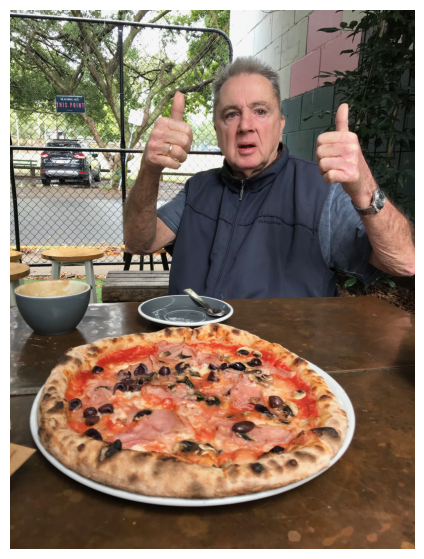

In [125]:
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0)) # matplotlib likes images in HWC (height, width, color_channels) format not CHW (color_channels, height, width)
plt.axis(False)

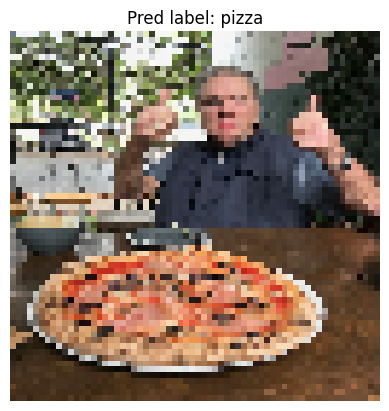

In [126]:
model_4.eval()
with torch.inference_mode():

  img = img / 255.

  resize = transforms.Resize((64, 64))
  img = resize(img)

  batch = img.unsqueeze(0).to(device)

  y_pred_logit = model_4(batch) 

  pred_label = torch.argmax(y_pred_logit, dim=1) 

plt.imshow(img.permute(1, 2, 0))
plt.title(f"Pred label: {class_names[pred_label]}")
plt.axis(False);